In [1]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


# Example-01: Filter initialization & Matrix representation

In [2]:
# Initialize Filter instance

# Data instance should be passed as the first argument
# Random seed is used only in randomized range estimation for approximate SVD computation

# Filter class contains several static and class method, that can be used without passing Data instance

f = Filter(None, random_seed=1)
print(f.data)
print(f.random_seed)

# make_matrix and make_signal functions can be used for matrix representation of a signal (Hankel matrix)
# Both functions act on a batch of signals and matrices, respectively

# Define test signal
signal = torch.linspace(1, 8, 8, dtype=torch.float64).unsqueeze(0)
print(signal.cpu().to(torch.int).numpy())

# Generate matrix representation
matrix = Filter.make_matrix(signal)
print(matrix.cpu().to(torch.int).numpy())

# Generate signal representation (average over skew diagonals)
print(Filter.make_signal(matrix).cpu().to(torch.int).numpy())

None
1
[[1 2 3 4 5 6 7 8]]
[[[1 2 3 4]
  [2 3 4 5]
  [3 4 5 6]
  [4 5 6 7]
  [5 6 7 8]]]
[[1 2 3 4 5 6 7 8]]


# Example-02: Singular values

In [3]:
# svd_list and svd_list_randomized can be used to compute singular values
# svd_list performs full SVD and svd_list_randimized performs randomized SVD
# In both cases, requested number of largest singular values is returned

# Generate test signal (real signal with three harmonics)
dtype = torch.float64
device = 'cpu'
length = 1024
time = torch.linspace(1, length, length, dtype=dtype, device=device)
signal = 1.0*torch.sin(2*numpy.pi*0.12*time) + 0.1*torch.sin(2*numpy.pi*0.24*time) + 1.E-3*torch.sin(2*numpy.pi*0.31*time)
signal.unsqueeze_(0)

# Generate matrix representation
matrix = Filter.make_matrix(signal)

# Since, test signal contains three harmonics, it's matrix is expected to have six non-zero singular values
torch.linalg.matrix_rank(matrix)

# Compute singular values (full SVD)
S1 = Filter.svd_list(rank=6, matrix=matrix, cpu=True)

# svd_list used full SVD to compute singular values
# number of returned singular values is set by rank parameter
# input matrix should be a batch of matrices
# cpu flag is used to compute SVD using CPU

# Compute singular values (randomized SVD)
S2 = Filter.svd_list_randomized(rank=6, matrix=matrix, buffer=8, count=8, random_seed=0, cpu=True)

# svd_list_randomized used randomized SVD to compute singular values
# randomized_range function is used to estimate matrix range with QR decomposition
# buffer parameter sets the number of extra dimensions, randomized range column rank is rank + buffer
# count parameter sets number of iterations
# random_seed is used for initialization

# Compare singular values
fmt = 3 * '{:<20.12}'
for s1, s2 in zip(S1.squeeze().cpu(), S2.squeeze().cpu()):
    print(fmt.format(s1, s2, abs(s1 - s2)))

256.518221536       256.518221536       5.68434188608e-14   
255.980457668       255.980457668       2.84217094304e-14   
25.6585560702       25.6585560702       7.1054273576e-15    
25.5899723888       25.5899723888       0.0                 
0.256513879015      0.256513879015      1.05471187339e-15   
0.255971936601      0.255971936601      6.66133814775e-16   


# Example-03: SVD truncation

tensor([4])
tensor([4])
256.508146204       256.508146204       1.13686837722e-13   
255.970590226       255.970590226       1.42108547152e-13   
25.6435936186       25.6435936186       1.7763568394e-14    
25.5754509016       25.5754509016       2.13162820728e-14   
3.476976521248273e-13
0.5993786989697338
0.599378698969838


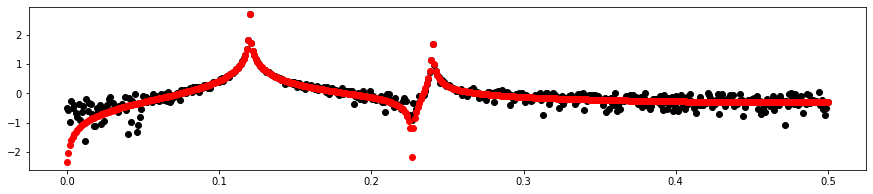

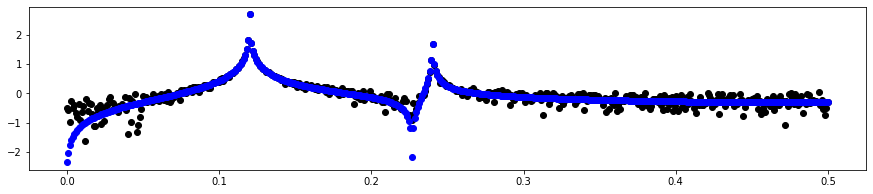

In [4]:
# svd_truncation and svd_truncation_randomized can be used to perform SVD truncation
# svd_truncation performs full SVD and svd_truncation_randomized performs randomized SVD
# In both cases, only the requested number of largest singular values are used to generated truncated matrix
# Truncated matrix is the best rank k approximation of the input
# These function return list of singular values and truncated matrices

# Generate test signal (real signal with two harmonics and random noise)
dtype = torch.float64
device = 'cpu'
length = 1024
time = torch.linspace(1, length, length, dtype=dtype, device=device)
signal = 1.0*torch.sin(2*numpy.pi*0.12*time) + 0.1*torch.sin(2*numpy.pi*0.24*time)
sigma = 1.0E-2
signal.add_(sigma*torch.randn(length, dtype=dtype, device=device))
signal.unsqueeze_(0)

# Generate matrix representation
matrix = Filter.make_matrix(signal)

# Since noise is added, matrix is expected to have full rank
torch.linalg.matrix_rank(matrix)

# Perform SVD truncation (full SVD)
S1, M1 = Filter.svd_truncation(rank=4, matrix=matrix, cpu=True)
print(torch.linalg.matrix_rank(M1))

# Perform SVD truncation (randomized SVD)
S2, M2 = Filter.svd_truncation_randomized(rank=4, matrix=matrix, buffer=8, count=8, random_seed=0, cpu=True)
print(torch.linalg.matrix_rank(M2))

# Compare singular values
fmt = 3 * '{:<20.12}'
for s1, s2 in zip(S1.squeeze().cpu(), S2.squeeze().cpu()):
    print(fmt.format(s1, s2, abs(s1 - s2)))
    
# Compare truncated matrices
print(torch.linalg.norm(M1-M2).cpu().numpy())

# Estimate noise
print(100*abs(sigma-torch.std(matrix - M1).cpu().numpy())/sigma)
print(100*abs(sigma-torch.std(matrix - M2).cpu().numpy())/sigma)

# Convert to signal representation and DFT compare spectra
s1 = Filter.make_signal(M1).squeeze()
s2 = Filter.make_signal(M2).squeeze()
grid = torch.fft.rfftfreq(length, dtype=dtype)
plt.figure(figsize=(15, 3))
plt.scatter(grid, torch.log10(torch.abs(torch.fft.rfft(signal.squeeze()))).cpu(), c='black')
plt.scatter(grid, torch.log10(torch.abs(torch.fft.rfft(s1))).cpu(), c='red')
plt.show()
plt.figure(figsize=(15, 3))
plt.scatter(grid, torch.log10(torch.abs(torch.fft.rfft(signal.squeeze()))).cpu(), c='black')
plt.scatter(grid, torch.log10(torch.abs(torch.fft.rfft(s2))).cpu(), c='blue')
plt.show()

# Filtering potentialy allows to apply window function with less noise amplification
# Note, signals are assumed to have zero mean
# Remove mean before processing or increase number of requested singular values by one

# Example-04: Optimal SVD truncation, rank and noise estimation

In [5]:
# estimate_noise function can be used for truncation rank and noise value estimation
# This function can be used when number of components in signal is not known

# Load test TbT data and add random noise
dtype = torch.float64
device = 'cpu'
length = 1024
win = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
tbt = Data.from_tensor(win, torch.tensor(numpy.load('../virtual_tbt.npy')[:, :length], dtype=dtype, device=device))
std = 1.E-4*torch.rand(54, dtype=dtype, device=device)
Data.add_noise(tbt.data, std)
tbt.reset()
print(tbt)

# Filter instance
f = Filter(tbt)

# For estimation, only several first columns can ne used (64 by default)
R1, N1 = f.estimate_noise(limit=16, cpu=True)
R2, N2 = f.estimate_noise(limit=64, cpu=True)
R3, N3 = f.estimate_noise(limit=256, cpu=True)

# Estimate noise (average over samples)
# Generate several samples of length 256 from each signal using start shift 8
N4 = []
for i in range(54):
    f = Filter(tbt.make_matrix(i, 256, 8))
    _, noise = f.estimate_noise(limit=64)
    N4.append(noise.mean().item())

Data(54, Window(1024, 'cosine_window', 1.0))


In [6]:
# Compare estimated ranks (note, expected rank is two)
fmt = 4 * '{:<6}'
print(fmt.format("", 16, 64, 256))
for i, (r1, r2, r3) in enumerate(zip(R1.cpu(), R2.cpu(), R3.cpu())):
    print(fmt.format(i, r1, r2, r3))
    
# Note, depending on particular noise parameters, results might be different
# In general, rank tends to be over estimated if large number of columns is used

      16    64    256   
0     2     4     4     
1     2     2     2     
2     2     2     2     
3     2     2     2     
4     2     2     2     
5     2     2     2     
6     2     2     2     
7     2     2     4     
8     2     2     4     
9     2     2     6     
10    2     2     2     
11    2     2     4     
12    2     2     4     
13    2     2     5     
14    2     2     2     
15    2     2     2     
16    2     2     2     
17    2     2     2     
18    2     2     2     
19    2     2     4     
20    2     2     2     
21    2     2     2     
22    2     2     4     
23    2     2     2     
24    2     2     2     
25    2     2     2     
26    2     2     4     
27    2     2     4     
28    2     2     5     
29    2     2     2     
30    2     2     2     
31    2     2     2     
32    2     2     2     
33    2     2     2     
34    2     2     2     
35    2     2     2     
36    2     2     6     
37    2     2     2     
38    2     2     2     


In [7]:
# Compare estimated noise
fmt = 5 * '{:<16}'
print(fmt.format("", 16, 64, 256, "ave"))
fmt = '{:<16}' + 4 * '{:<16.8}'
for i, (n0, n1, n2, n3, n4) in enumerate(zip(std.cpu(), N1.cpu(), N2.cpu(), N3.cpu(), N4)):
    print(fmt.format(i, 100*abs(n1-n0)/n0, 100*abs(n2-n0)/n0, 100*abs(n3-n0)/n0, 100*abs(n4-n0)/n0))
    
# Note, for noise sigma estimation, approximate expression is used
# In this example, noise estimation accuracy is better than 10%
# Using larger number of columns or averaging over samples do not affect estimation accuracy significantly (but better on average in both cases)

                16              64              256             ave             
0               7.6177223       3.6503608       6.6503644       2.2813106       
1               0.50477224      1.682291        0.58419474      1.5876059       
2               1.7428685       0.65950903      0.93449122      1.4006352       
3               3.7464685       1.3476199       1.1082647       0.045203966     
4               6.8322246       5.1663288       6.5903629       8.9951808       
5               2.3788745       3.6745596       0.4810288       0.44044279      
6               9.4947635       6.1175316       4.2701819       8.0192824       
7               3.635914        1.9792113       2.0263077       0.42106898      
8               0.27340766      1.7977394       2.8163681       0.41626287      
9               1.5642087       3.826295        4.2553263       1.7231383       
10              1.4436487       0.7740576       1.40227         2.0670347       
11              1.092699    

# Example-05: RPCA

In [8]:
# https://arxiv.org/abs/0912.3599
# RPCA can be performed with rpca classmethod
# Single matrix should be passed on input (this can be a full TbT matrix or a Hankel matrix of a signal)

# Separate 'grained' noise using RPCA

# Generate original low rank matrix
n = 100
k = 3
m = 40
X = numpy.hstack([numpy.ones((n, m)) * (i + 1) * 10 for i in range(k)])
print(X.shape)
print(X)
print(torch.linalg.matrix_rank(torch.tensor(X)))

# Generate matrix with missing values (change fraction of missing values to observe convergence)
Y = numpy.copy(X)
Y[numpy.random.rand(*Y.shape) < 0.1] = 0.0
print(Y.shape)
print(Y)
print(torch.linalg.matrix_rank(torch.tensor(Y)))

# Perform RPCA (change the number of iterations and/or the tolerance factor to observe convergence)
count, error, L, S = Filter.rpca(torch.tensor(Y), limit=8912, factor=1.E-12, cpu=True)

# Number of iterations and final error
print(count)
print(error)

# 'Cleaned' matrix rank
print(torch.linalg.matrix_rank(L))
print(L.cpu().numpy())

# Maximum element-wise error
print(numpy.max(numpy.abs((X - L.cpu().numpy()))))

(100, 120)
[[10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 ...
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]]
tensor(1)
(100, 120)
[[10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30.  0. 30.]
 [10. 10.  0. ... 30.  0. 30.]
 ...
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]]
tensor(100)
378
tensor(1.915177428056e-10, dtype=torch.float64)
tensor(1)
[[10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 ...
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]
 [10. 10. 10. ... 30. 30. 30.]]
2.7533531010703882e-11


# Example-06: TbT filtering (SVD & Hankel & RPCA)

In [9]:
# In this example frequency uncertanty is compared for different TbT filtering

In [10]:
# Compute reference frequency for test TbT data

# Load TbT
dtype = torch.float64
device = 'cpu'
length = 4096
win = Window(length, 'cosine_window', 2.0, dtype=dtype, device=device)
tbt = Data.from_tensor(win, torch.tensor(numpy.load('../virtual_tbt.npy')[:, :length], dtype=dtype, device=device))

# Compute reference frequency
f = Frequency(tbt)
f('parabola')
ref = f.frequency.mean().cpu().item()
print(ref)

0.46148590441619713


In [11]:
# Set parameters
dtype = torch.float64
device = 'cpu'
length = 1024

# Set noise std for each BPM
# Note, each BPM has a different value of noise sigma
std = 1.0E-4*torch.rand(54, dtype=dtype, device=device)

# Test TbT data with random noise
win = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
tbt = Data.from_tensor(win, torch.tensor(numpy.load('../virtual_tbt.npy')[:, :length], dtype=dtype, device=device))
Data.add_noise(tbt.data, std.to(dtype).to(device))
tbt.reset()

# Set seed (randomized range estimation)
seed = numpy.random.randint(0, 1000)

# Set filter instance
flt = Filter(tbt, random_seed=seed)

# Set frequency instance
fre = Frequency(tbt)

In [12]:
# Estimate noise (optimal SVD truncation)
_, noise = flt.estimate_noise(limit=32, cpu=True)

# Maximum noise estimation error
print(torch.max(100*torch.abs(noise - std)/std).cpu().item())

8.523581542617128


In [13]:
# Compute frequencies without filtering
# Note, since error is random, i.e. deviation of mean from the reference
# The result should be judged mostly by frequency spread (assuming bias can be neglected)
f = Frequency(tbt)

# Without window
f('parabola', window=False)
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: raw data without window')

# With window
# Note, in general, window will increase frequency spread, but reduce bias
f('parabola', window=True)
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: raw data with window')

error: 8.1130052e-08    spread: 2.52871944e-06   case: raw data without window
error: 2.091952e-07     spread: 1.00703458e-06   case: raw data with window


In [14]:
# Perform SVD filtering (full TbT)
# Note, filter modifies work container of TbT, computation of frequency resets work container if window is used
flt.filter_svd(rank=2, cpu=True)

# Maximum noise estimation error
noise = torch.std(tbt.data - tbt.work, 1)
print(torch.max(100*torch.abs(noise - std)/std).cpu().item())

# Compute frequencies with SVD filtering

# Without window
# Note, frequency spread is generaly reduced by SVD filtering
f('parabola', window=False)
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: SVD filtering without window')

# With window
# Note, filtering allows application of window without harmful effect on frequency spread
# In some cases frequency spread is further reduced
f('parabola', window=True)
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: SVD filtering with window')

533.4385865798112
error: 1.56799006e-07   spread: 2.43066462e-06   case: SVD filtering without window
error: 2.57954144e-07   spread: 7.29394137e-08   case: SVD filtering with window


In [15]:
# Perform Hankel filtering
# Note, when applied to raw TbT, Hankel filtering performs worse than SVD
flt.filter_hankel(rank=2, cpu=True, random=True, buffer=16, count=32)

# Maximum noise estimation error
noise = torch.std(tbt.data - tbt.work, 1)
print(torch.max(100*torch.abs(noise - std)/std).cpu().item())

# Compute frequencies with Hankel filtering

# Without window
f('parabola', window=False)
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: Hankel filtering without window')

# With window
f('parabola', window=True)
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: Hankel filtering with window')

4.725072364787726
error: 2.18310542e-07   spread: 2.58049435e-06   case: Hankel filtering without window
error: 1.5771785e-07    spread: 8.8182188e-07    case: Hankel filtering with window


In [16]:
# Perform SVD & Hankel filtering
# If Hankel filtering is applied after SVD, the frequency spread is further slightly reduced on average
flt.filter_svd(rank=2, cpu=True)
flt.filter_hankel(rank=2, cpu=True, random=True, buffer=8, count=16)

# Maximum noise estimation error
noise = torch.std(tbt.data - tbt.work, 1)
print(torch.max(100*torch.abs(noise - std)/std).cpu().item())

# Without window
f('parabola', window=False)
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: SVD & Hankel filtering without window')

# With window
f('parabola', window=True)
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: SVD & Hankel filtering with window')

14.907824795769596
error: 2.7789705e-07    spread: 2.40834492e-06   case: SVD & Hankel filtering without window
error: 2.11268914e-07   spread: 6.39309547e-08   case: SVD & Hankel filtering with window


In [17]:
# Perform RPCA filtering
# Note, RPCA is not perfect for normal noise, large number of iterations is required in this case
flt.filter_rpca(limit=2**10, factor=1.E-15, cpu=True)

# Maximum noise estimation error
noise = torch.std(tbt.data - tbt.work, 1)
print(torch.max(100*torch.abs(noise - std)/std).cpu().item())

# Without window
f('parabola', window=False)
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: RPCA filtering without window')

# With window
f('parabola', window=True)
m, s = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'error: {abs(ref - m):<16.9} spread: {s:<16.9} case: RPCA filtering with window')

# RPCA can be combined also combined with other filters

221.1715107856178
error: 1.13925958e-07   spread: 2.41581273e-06   case: RPCA filtering without window
error: 2.50763706e-07   spread: 4.01000314e-07   case: RPCA filtering with window


# Example-07: Effect of filtering on uncertainties

In [18]:
# Estimate frequency and amplitude uncertainty from multiple realizations

# Set parameters
dtype = torch.float64
device = 'cpu'
length = 1024

# Set signal
time = torch.linspace(1, length, length, dtype=dtype, device=device)
signal = 1.0*torch.cos(2.0*numpy.pi*0.12345*time) + 0.1*torch.cos(2.0*numpy.pi*2.0*0.12345*time)

# Set TbT (signal copies with different noise realizations)
std = 0.10
win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)
tbt = torch.stack([signal + std*torch.randn(length, dtype=dtype, device=device) for _ in range(256)])
tbt = Data.from_tensor(win, tbt)

# Estimate frequency
f = Frequency(tbt)
f('parabola')
m_f, s_f = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()

# Print result
print(f'frequency: error={abs(0.12345 - m_f):<16.12}, spread={s_f:<16.12}')

# Estimate amplitude
c = 2.0/win.total*torch.sum(torch.cos(2.0*numpy.pi*m_f*time)*tbt.data*win.data, 1)
s = 2.0/win.total*torch.sum(torch.sin(2.0*numpy.pi*m_f*time)*tbt.data*win.data, 1)
a = torch.sqrt(c*c + s*s)
m_a, s_a = a.mean().cpu().item(), a.std().cpu().item()

# Print result
print(f'amplitude: error={abs(1.0 - m_a):<16.12}, spread={s_a:<16.12}')

frequency: error=1.28052105364e-07, spread=3.72335044926e-06
amplitude: error=2.27846163471e-05, spread=0.00562484018989


In [19]:
# Estimate rank/noise
flt = Filter(tbt)
rank, noise = flt.estimate_noise(limit=32, cpu=True)
print(f'min: {rank.min().cpu().item()}')
print(f'max: {rank.max().cpu().item()}')
print(f'std: {noise.mean().cpu().item()}')

min: 4
max: 4
std: 0.1012254517915858


In [20]:
# SVD

# Estimate frequency
flt.filter_svd(rank=4, random=False, cpu=True)
f = Frequency(tbt)
f('parabola')
m_f, s_f = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'frequency: error={abs(0.12345 - m_f):<16.12}, spread={s_f:<16.12}')

# Estimate amplitude
flt.filter_svd(rank=4, random=False, cpu=True)
c = 2.0/win.total*torch.sum(torch.cos(2.0*numpy.pi*m_f*time)*tbt.work*win.data, 1)
s = 2.0/win.total*torch.sum(torch.sin(2.0*numpy.pi*m_f*time)*tbt.work*win.data, 1)
a = torch.sqrt(c*c + s*s)
m_a, s_a = a.mean().cpu().item(), a.std().cpu().item()
print(f'amplitude: error={abs(1.0 - m_a):<16.12}, spread={s_a:<16.12}')

frequency: error=1.28102835104e-07, spread=3.84862827805e-07
amplitude: error=3.55922919033e-05, spread=0.00461545837535


In [21]:
# SVD & Hankel

# Estimate frequency
flt.filter_svd(rank=4, random=False, cpu=True)
flt.filter_hankel(rank=4, random=True, buffer=8, count=16, cpu=True)
f = Frequency(tbt)
f('parabola')
m_f, s_f = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'frequency: error={abs(0.12345 - m_f):<16.12}, spread={s_f:<16.12}')

# Estimate amplitude
flt.filter_svd(rank=4, random=False, cpu=True)
flt.filter_hankel(rank=4, random=True, buffer=8, count=16, cpu=True)
c = 2.0/win.total*torch.sum(torch.cos(2.0*numpy.pi*m_f*time)*tbt.work*win.data, 1)
s = 2.0/win.total*torch.sum(torch.sin(2.0*numpy.pi*m_f*time)*tbt.work*win.data, 1)
a = torch.sqrt(c*c + s*s)
m_a, s_a = a.mean().cpu().item(), a.std().cpu().item()
print(f'amplitude: error={abs(1.0 - m_a):<16.12}, spread={s_a:<16.12}')

frequency: error=1.86836980748e-07, spread=2.441272885e-07 
amplitude: error=2.7220889757e-05, spread=0.00461352704517


In [22]:
# RPCA

# Estimate frequency
flt.filter_rpca(limit=4096, factor=1.E-12, cpu=True)
f = Frequency(tbt)
f('parabola')
m_f, s_f = f.frequency.mean().cpu().item(), f.frequency.std().cpu().item()
print(f'frequency: error={abs(0.12345 - m_f):<16.12}, spread={s_f:<16.12}')

# Estimate amplitude
flt.filter_rpca(limit=4096, factor=1.E-12, cpu=True)
c = 2.0/win.total*torch.sum(torch.cos(2.0*numpy.pi*m_f*time)*tbt.work*win.data, 1)
s = 2.0/win.total*torch.sum(torch.sin(2.0*numpy.pi*m_f*time)*tbt.work*win.data, 1)
a = torch.sqrt(c*c + s*s)
m_a, s_a = a.mean().cpu().item(), a.std().cpu().item()
print(f'amplitude: error={abs(1.0 - m_a):<16.12}, spread={s_a:<16.12}')

frequency: error=1.86836941141e-07, spread=2.44127601146e-07
amplitude: error=0.00791485396422, spread=0.0053367138622 
